# **ASSIGNMENT 3**

**Task**: forecast the real price of gasoline for the US.

**Dataset**: gasoline.xlsx contains two monthly time series. The nominal price of gasoline and the CPI. 


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from fredapi import Fred


pd.set_option("display.precision", 2)

In [32]:
fred_key = '17193bb5d3d0af2508e249e344961fcf'
fred = Fred(api_key=fred_key)

In [33]:
def get_fred_data(code):
    return fred.get_series(code, frequency = 'q')

fred_codes = {'CPI' : 'CPIAUCSL',
              'Nominal_Price' : 'GASREGW'}

gasoline = pd.DataFrame()

for var in fred_codes.keys():
    gasoline[var] = get_fred_data(fred_codes[var])

In [34]:
gasoline['Time'] = pd.to_datetime(gasoline.index)
gasoline = gasoline.query("Time >= '1990-11-01'")
gasoline.head()

,CPI,Nominal_Price,Time
1991-01-01,134.77,1.09,1991-01-01
1991-04-01,135.57,1.11,1991-04-01
1991-07-01,136.60,1.11,1991-07-01
1991-10-01,137.73,1.09,1991-10-01
1992-01-01,138.67,1.01,1992-01-01


# 1) create the real price of gasoline

CPI has value = 100 for 1984: is it meaningful, considering that the observations begin from 1990?

In [35]:
gasoline['Real_Price'] = (gasoline['Nominal_Price']/gasoline['CPI'])*100
gasoline.head(5)

,CPI,Nominal_Price,Time,Real_Price
1991-01-01,134.77,1.09,1991-01-01,0.81
1991-04-01,135.57,1.11,1991-04-01,0.82
1991-07-01,136.60,1.11,1991-07-01,0.81
1991-10-01,137.73,1.09,1991-10-01,0.79
1992-01-01,138.67,1.01,1992-01-01,0.73


It should be: nominal/cpi_base_year*cpi_present_year

## 2)  Plot real and nominal prices over time.

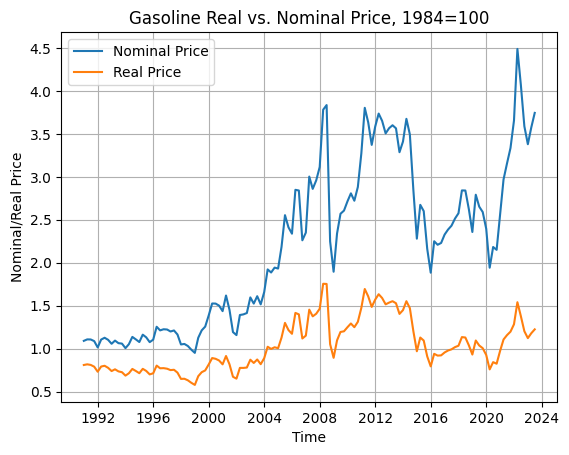

In [36]:
plt.plot(gasoline['Time'], gasoline['Nominal_Price'], label = 'Nominal Price')
plt.plot(gasoline['Time'], gasoline['Real_Price'], label='Real Price')

plt.title('Gasoline Real vs. Nominal Price, 1984=100')
plt.xlabel('Time')
plt.ylabel('Nominal/Real Price')
plt.legend()
plt.grid()

Alternatively, plot them separately. Be aware of the different y-axis!

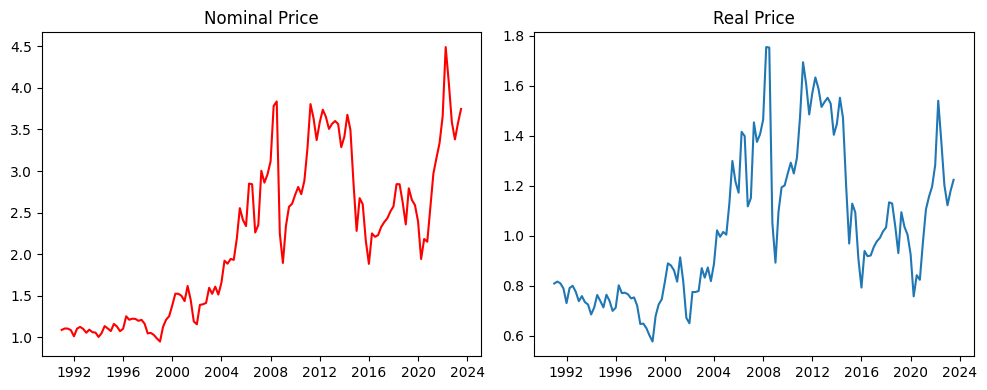

In [37]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
ax[0].plot(gasoline['Time'], gasoline['Nominal_Price'], color='red')
ax[0].set_title('Nominal Price')

ax[1].plot(gasoline['Time'], gasoline['Real_Price'])
ax[1].set_title('Real Price')

plt.tight_layout()
plt.show()

## 3) Consider the sample from obs 1 to Dec 2014. Plot the sample ACF of $y_{t}$ and $\Delta{y_t} = y_{t} - y_{t-1}$


In [38]:
# filter the data as requestes
filtered_gasoline = gasoline.query(" Time <= '2014-12-01'")

# convert the data from float to numeric...
filtered_gasoline['Real_Price'] = pd.to_numeric(filtered_gasoline['Real_Price'], errors='coerce')

# ... otherwise we couldn't apply the .log() function
filtered_gasoline['Log_Real_Price'] = np.log(filtered_gasoline['Real_Price'])

# create the column delta for the first difference of the log price
filtered_gasoline['Delta_Log'] = (filtered_gasoline['Log_Real_Price']-filtered_gasoline['Log_Real_Price'].shift(1))

# fill the first value with 0, otherwise the next code chunk won't produce an accurate ACF
filtered_gasoline['Delta_Log'].fillna(0, inplace=True)

filtered_gasoline.tail()

C:\Users\giord\AppData\Local\Temp\ipykernel_34048\4129526131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gasoline['Real_Price'] = pd.to_numeric(filtered_gasoline['Real_Price'], errors='coerce')
C:\Users\giord\AppData\Local\Temp\ipykernel_34048\4129526131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gasoline['Log_Real_Price'] = np.log(filtered_gasoline['Real_Price'])
C:\Users\giord\AppData\Local\Temp\ipykernel_34048\4129526131.py:11: SettingWithCopyWarning: 
A value is trying

,CPI,Nominal_Price,Time,Real_Price,Log_Real_Price,Delta_Log
2013-10-01,234.16,3.29,2013-10-01,1.40,0.34,-0.08
2014-01-01,235.62,3.41,2014-01-01,1.45,0.37,0.03
2014-04-01,236.87,3.68,2014-04-01,1.55,0.44,0.07
2014-07-01,237.48,3.49,2014-07-01,1.47,0.39,-0.05
2014-10-01,236.89,2.85,2014-10-01,1.20,0.18,-0.20


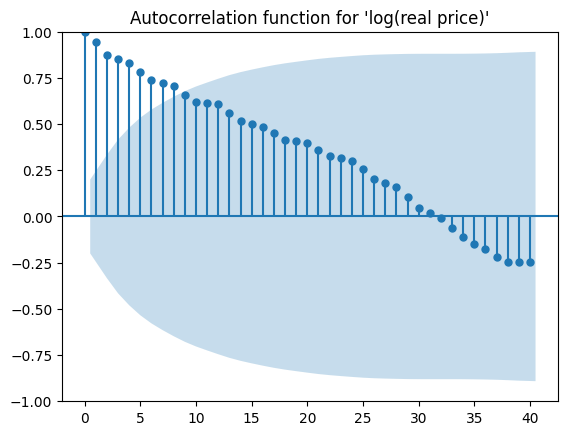

In [39]:
plot_acf(filtered_gasoline['Log_Real_Price'], 
         lags=40,
         title="Autocorrelation function for 'log(real price)'");

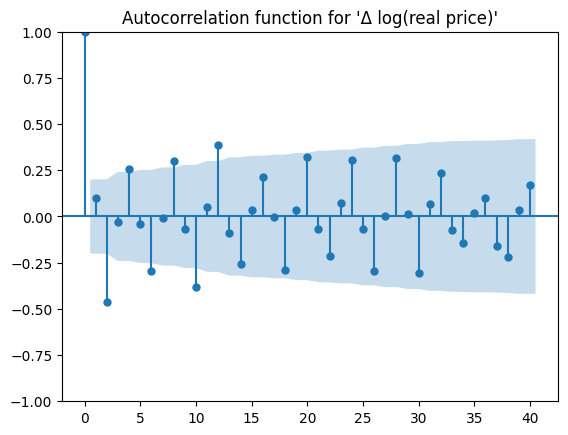

In [40]:
plot_acf(filtered_gasoline['Delta_Log'], 
         lags=40, 
         title="Autocorrelation function for 'Δ log(real price)'");

## 4) Using the same sample above fit two AR(1) models: the first for **$y_{t}$** and the second for **Δ$y_{t}$**. Report in both cases the coefficient associated with the lagged dependent variable.


In [41]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
# If the pvalue is above a critical size, then we cannot reject that there is a unit root.

stationarity_test = adfuller(filtered_gasoline['Log_Real_Price'], autolag='AIC')
stationarity_test

(-0.8907071941425867,
 0.791017265753321,
 2,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 -157.46963714092695)

Since the critical value, -1.10, is > than t-values at (1%,5%,10%), the null hypothesis CANNOT be rejected, where the null hypothesis is that there exists a unit root. If there exists a unit root, then the process is NON-stationary.


In my case, the ADF statistic is greater than the critical values. This suggests that the null hypothesis of a unit root is not rejected, indicating that the time series might indeed be NON-stationary (= it has relation with time).

Moreover, the p-value exceed the significance level of 0.01, 0.05, 0.1.

In [42]:
ar_log_real_price = AutoReg(filtered_gasoline['Log_Real_Price'], lags=1).fit()
print(ar_log_real_price.summary())

                            AutoReg Model Results                             
Dep. Variable:         Log_Real_Price   No. Observations:                   96
Model:                     AutoReg(1)   Log Likelihood                  85.856
Method:               Conditional MLE   S.D. of innovations              0.098
Date:                Fri, 20 Oct 2023   AIC                           -165.712
Time:                        14:56:10   BIC                           -158.050
Sample:                    04-01-1991   HQIC                          -162.616
                         - 10-01-2014                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0027      0.010      0.272      0.786      -0.017       0.023
Log_Real_Price.L1     0.9498      0.032     29.424      0.000       0.887       1.013
                        

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [43]:
stationarity_test2 = adfuller(filtered_gasoline['Delta_Log'], autolag='AIC')
stationarity_test2

(-10.72206220123046,
 3.1325158505088793e-19,
 1,
 94,
 {'1%': -3.5019123847798657,
  '5%': -2.892815255482889,
  '10%': -2.583453861475781},
 -158.12284339383163)

In [44]:
ar_delta_log = AutoReg(filtered_gasoline['Delta_Log'], lags=1).fit()
print(ar_delta_log.summary())

                            AutoReg Model Results                             
Dep. Variable:              Delta_Log   No. Observations:                   96
Model:                     AutoReg(1)   Log Likelihood                  85.185
Method:               Conditional MLE   S.D. of innovations              0.099
Date:                Fri, 20 Oct 2023   AIC                           -164.371
Time:                        14:56:10   BIC                           -156.709
Sample:                    04-01-1991   HQIC                          -161.275
                         - 10-01-2014                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0035      0.010      0.345      0.730      -0.016       0.023
Delta_Log.L1     0.1072      0.104      1.026      0.305      -0.098       0.312
                                    Roots   

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


## 5) Produce a series of 1 step-ahead forecasts for yt. Use the following models: random walk (no drift), ARIMA(1,1,0), ARIMA(0,1,1), ARIMA(1,1,1). To produce forecasts start from the sample that ends in Dec 2014 and add 1 observation at the time (i.e. expanding/recursive scheme)